In [4]:
import os
import torch
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow

In [5]:
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
@torch.inference_mode()
def visualize_prompts(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        latents.append(pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            output_type="latent",
        ).images)
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs

In [6]:
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/utils")
from pixart_utils import state_dict_convert
from image_utils import pil_images_to_grid

In [8]:
from os.path import join
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

In [11]:
mixed_precision = "fp16"
weight_dtype = torch.float32
if mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16

In [12]:
# config.dump(os.path.join(config.work_dir, 'config.py'))
config = read_config(join(savedir, 'config.py'))
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2024-11-27 19:59:54,668 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
ckptdir = join(savedir, "checkpoints")
validation_prompts = config.validation_prompts
prompt_cache_dir = config.prompt_cache_dir
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
model.load_state_dict(ckpt['state_dict_ema']) # 'state_dict'

<All keys matched successfully>

In [14]:
list(ckpt)

['state_dict', 'state_dict_ema', 'optimizer', 'scheduler', 'epoch']

In [22]:
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema'])) # model.state_dict()
# visualize the prompts
image_logs = visualize_prompts(pipeline, validation_prompts, prompt_cache_dir, config.model_max_length, weight_dtype)

In [25]:
pipeline

PixArtAlphaPipeline {
  "_class_name": "PixArtAlphaPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "PixArt-alpha/PixArt-XL-2-512x512",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [24]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [23]:
image_logs

[{'validation_prompt': 'triangle is to the upper left of square',
  'images': [<PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image imag

In [26]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

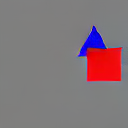

In [21]:
image_logs[0]['images'][0]